In [1]:
%%bash
wget https://raw.githubusercontent.com/TalSchuster/FeverSymmetric/refs/heads/master/symmetric_v0.2/fever_symmetric_dev.jsonl
wget https://raw.githubusercontent.com/TalSchuster/FeverSymmetric/refs/heads/master/symmetric_v0.2/fever_symmetric_test.jsonl

--2025-06-20 03:26:53--  https://raw.githubusercontent.com/TalSchuster/FeverSymmetric/refs/heads/master/symmetric_v0.2/fever_symmetric_dev.jsonl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 466743 (456K) [text/plain]
Saving to: ‘fever_symmetric_dev.jsonl’

     0K .......... .......... .......... .......... .......... 10% 9.29M 0s
    50K .......... .......... .......... .......... .......... 21% 11.1M 0s
   100K .......... .......... .......... .......... .......... 32% 32.2M 0s
   150K .......... .......... .......... .......... .......... 43% 56.7M 0s
   200K .......... .......... .......... .......... .......... 54% 15.4M 0s
   250K .......... .......... .......... .......... .......... 65% 60.6M 0s
   300K .......... .......... .......... .......... 

In [2]:
import pandas as pd

dev_json='/kaggle/working/fever_symmetric_dev.jsonl'
test_json='/kaggle/working/fever_symmetric_test.jsonl'


df_dev = pd.read_json(dev_json, lines=True)
df_dev.head()

,id,claim,evidence,sentence1,sentence2,gold_label,label,evid
0,54253,Daggering is associated with the genre of deat...,"It is of recent origin , associated with the 2...","It is of recent origin , associated with the 2...",Daggering is associated with the genre of deat...,REFUTES,REFUTES,"[[It is of recent origin , associated with the..."
1,204361,The Cretaceous ended .,The Cretaceous ended with a large mass extinct...,The Cretaceous ended with a large mass extinct...,The Cretaceous ended .,SUPPORTS,SUPPORTS,[[The Cretaceous ended with a large mass extin...
2,114897,Penélope Cruz refused to model for L'Oréal .,"Cruz has modelled for Mango , Ralph Lauren and...","Cruz has modelled for Mango , Ralph Lauren and...",Penélope Cruz refused to model for L'Oréal .,REFUTES,REFUTES,"[[Cruz has modelled for Mango , Ralph Lauren a..."
3,78305,Lost is a political party .,Lost is an American television drama series th...,Lost is an American television drama series th...,Lost is a political party .,REFUTES,REFUTES,[[Lost is an American television drama series ...
4,170406,"Michael Vick graduated college on June 26th , ...","Michael Dwayne Vick -LRB- born June 26 , 1980 ...","Michael Dwayne Vick -LRB- born June 26 , 1980 ...","Michael Vick graduated college on June 26th , ...",REFUTES,REFUTES,"[[Michael Dwayne Vick -LRB- born June 26 , 198..."


In [3]:
df_test = pd.read_json(test_json, lines=True)

combine_df=pd.concat([df_dev,df_test], ignore_index=True).head(1200)
combine_df.shape

(1200, 8)

In [4]:
# Shuffle with a fixed random seed
df = combine_df.sample(frac=1, random_state=42).reset_index(drop=True)
df.shape

(1200, 8)

In [5]:
import os
import glob

folder_name='/kaggle/working/'
jsonl_files=glob.glob(os.path.join(folder_name,'*.jsonl'))

for f_p in jsonl_files:
    try:
        os.remove(f_p)
        print(f"Deleted: {f_p}")
    except Exception as e:
        print(f"Error deleting {f_p}: {e}")

Deleted: /kaggle/working/fever_symmetric_test.jsonl
Deleted: /kaggle/working/fever_symmetric_dev.jsonl


# Building Reasoning Paths for FEVER

we will generate multiple resoning paths by using LLM and follow the SoT prompt strategy.

id	claim	evidence	sentence1	sentence2	gold_label	label	evid

In [6]:
from typing import Optional,List,Union
from pydantic import BaseModel

class Entity(BaseModel):
    id: int
    claim: str
    evidence: str
    sentence1: str
    sentence2: str
    gold_label: str
    label: str
    evid: List[List[Union[str, float]]]

class ReasoningPath(BaseModel):
    question: str
    evidence: str
    reason: str
    answer: Optional[str]=None
    ground_truth: str
    temperature: float
    tokens: int
    score: float

entities = [Entity.model_validate(row) for row in df.to_dict(orient='records')]

In [7]:
import re
from sketch_of_thought import SoT
from typing import Tuple, Union
from doraemon import Doraemon

logger=Doraemon.get_logger(name=__name__, logfile="fever_dataset_builder.log")

def get_answer(raw_answer: str)-> str:
    answer=re.search(r'\\boxed{([^}]+)}', raw_answer)
    if answer:
        return answer.group(1)
    return None
    

def process_entity(args)-> Optional[ReasoningPath]:
    """
    """
    et,paradigm,temperature=args

    try:
        prompt=SoT.few_short_support(
            task_name='FEVER', 
            prompt=SoT.get_initialized_prompt(paradigm=paradigm), 
            few_short=SoT.get_few_short(task_name='FEVER'),
            question=f"Question:{et.claim}\nContext:{et.evidence}"
        )
        
        r_s, tokens=Doraemon.inference(
            logger=logger, 
            messages=prompt, 
            temperature=temperature
        )
        
        result=ReasoningPath(
            question=str(et.claim), 
            evidence=str(et.evidence), 
            reason=str(r_s), 
            answer=get_answer(r_s),
            ground_truth=str(et.gold_label),
            temperature=float(temperature), 
            tokens=int(tokens), 
            score=0.0)
        return result
    except Exception as e:
        logger.error(f"Error processing quetion {et.claim} at temperature {temperature} with exception {e}")
        return None


paradigm = SoT.classify_question(entities[0].claim)
logger.info(paradigm)
assert "conceptual_chaining"==str(paradigm)

2025-06-20 03:27:17.815719: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750390038.056680      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750390038.130123      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


tokenizer_config.json:   0%|          | 0.00/1.25k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/769 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

2025-06-20 03:27:38,544 INFO conceptual_chaining


In [8]:
temperatures = [i * 0.25 for i in range(9)]  # [0.0, 0.25, 0.5, ... ,2.0]

tasks=[]
for et in entities:
    for tp in temperatures:
        tasks.append((et,paradigm,tp))

In [9]:
from tqdm import tqdm
from typing import List, Dict
import concurrent.futures

with concurrent.futures.ProcessPoolExecutor(max_workers=1) as executor:
    results=list(tqdm(executor.map(process_entity, tasks), total=len(tasks)))

100%|██████████| 10800/10800 [2:57:27<00:00,  1.01it/s]


# Convert Data into pkl File 

In [10]:
final_list:List[Dict] = [rp.model_dump() for rp in results if rp is not None]

final_df=pd.DataFrame(final_list)

mapping = {'true': 'SUPPORTS', 'false': 'REFUTES'}
final_df['answer'] = final_df['answer'].str.lower().map(mapping).fillna(final_df['answer'])

final_df.to_pickle('cots_df.pkl')

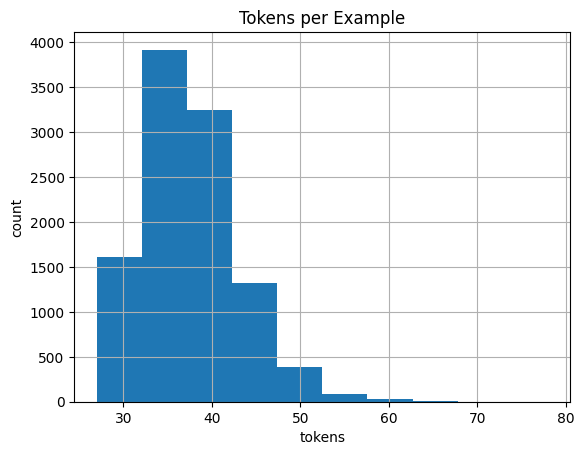

In [11]:
import matplotlib.pyplot as plt

# Tokens distribution
plt.figure()
final_df['tokens'].hist()
plt.title("Tokens per Example")
plt.xlabel("tokens")
plt.ylabel("count")
plt.show()